# **Chapter 6: Synchronization Tools – Exercises**

## **6.12 Array-Based Stack Race Condition**

**Question:**  
The pseudocode of Figure 6.15 illustrates basic `push()` and `pop()` operations for an array-based stack. Assuming concurrent use:


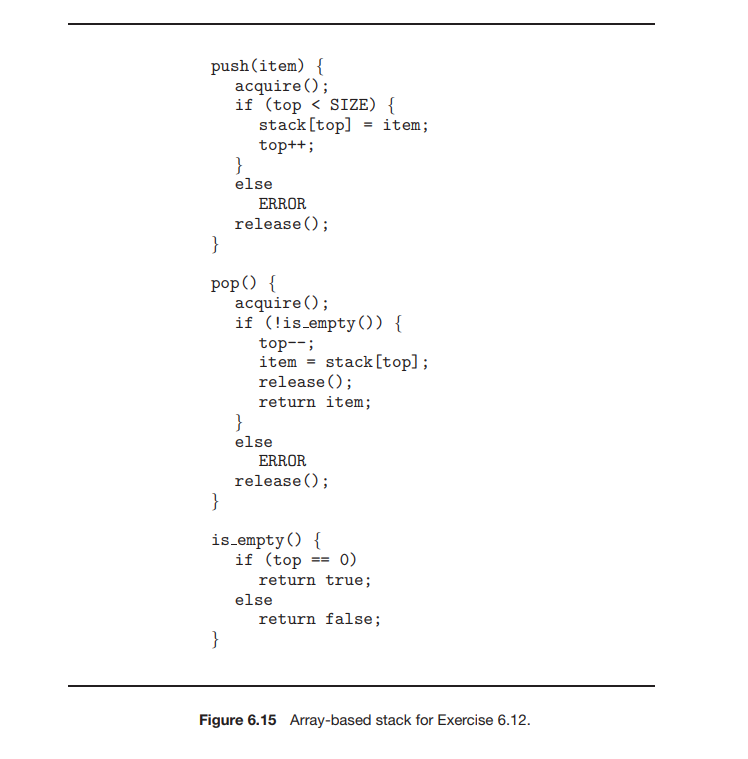


a. What data have a race condition?  
b. How could the race condition be fixed?

**Answer:**  
**a. Race condition data:**  
- The `top` index variable.  
- The `stack[]` array elements (particularly near `top`).

**Explanation:**  
If two threads concurrently execute `push()` (or `pop()`, or one of each), they may read the same `top` value, leading to:
1. **Lost push:** Two items written to same index, one overwritten.
2. **Incorrect pop:** Same item popped twice.
3. **Stack corruption:** `top` increment/decrement interleaving causes index out of bounds or incorrect state.

**b. Fix:**  
Use a **mutex lock** (binary semaphore) to make the entire `push()` or `pop()` operation atomic. The given code already shows `acquire()` and `release()` calls, which must be implemented correctly to protect the critical sections.


## **Exercise 6.13**
**Question:**  
Race conditions are possible in many computer systems. Consider an online auction system where the current highest bid for each item must be maintained. A person who wishes to bid on an item calls the bid(amount) function, which compares the amount being bid to the current highest bid. If the amount exceeds the current highest bid, the highest bid is set to the new amount. This is illustrated below:
```
void bid(double amount) {
if (amount > highestBid)
highestBid = amount;
}
```
Describe how a race condition is possible in this situation and what might be done to prevent the race condition from occurring.

**Answer:**  
**Race Condition Scenario:**  
Two bidders, A and B, simultaneously call `bid()` with amounts `amount_A` and `amount_B`, both greater than the current `highestBid`. They may both execute the `if` condition concurrently, reading the same old `highestBid` value. Both will then update `highestBid`. Whichever update occurs last will set the final value, causing the **loss of the higher bid** if it was written first. For example, if `highestBid` starts at $100, A bids $150, and B bids $200. Both read $100, A writes $150, then B overwrites with $200 (correct outcome here, but only by luck). However, if execution order reverses, B writes $200 first, then A overwrites with $150, resulting in an incorrect lower "highest" bid.

**Prevention:**  
Make the `bid()` operation **atomic**. This can be achieved by:
1. Using a **mutex lock** to protect the entire function.
2. Using an **atomic `compare_and_swap()`** instruction on `highestBid` in a loop: read current value, if `amount > current`, attempt to swap. Retry if the value changed concurrently.
3. Implementing the bid logic as a critical section using any synchronization primitive that ensures mutual exclusion.

---

## **Exercise 6.14**
**Question:**  
The following program example can be used to sum the array values of size N elements in parallel on a system containing N computing cores (there is a separate processor for each array element):
```
for j = 1 to log2(N) {
for k = 1 to N {
if ((k + 1) % pow(2,j) == 0) {
values[k] += values[k - pow(2,(j-1))]
}
}
}
```
This has the effect of summing the elements in the array as a series of partial sums, as shown in Figure 6.16. After the code has executed, the sum of all elements in the array is stored in the last array location. Are there any race conditions in the above code example? If so, identify where they occur and illustrate with an example. If not, demonstrate why this algorithm is free from race conditions.

**Answer:**  
**Yes, there are race conditions** in the provided parallel code. The algorithm is designed for a **sequential execution** (as written by the nested loops). If run in parallel with one thread per array index `k`, multiple threads will read and write shared array elements concurrently in a non-atomic way within the same iteration of `j`.

**Where they occur:**  
In a given iteration `j`, multiple threads `k` that satisfy `(k+1) % 2^j == 0` will execute `values[k] += values[k - 2^(j-1)]`. However, the element `values[k - 2^(j-1)]` might simultaneously be:
1. Read by multiple threads targeting different `k'` indices.
2. Updated by another thread if it is itself a `values[k]` for a *smaller* `k` in the same `j` iteration (this depends on the pattern, but the dependencies are not synchronized).
3. Updated in a *later* iteration of `j` by a thread, while it is still being read in an earlier `j` iteration if parallelism is across `j` as well.

**Example with N=4 (values[0..3] initially 1,2,3,4):**  
- *j=1*: Threads for k=1,3 are active. Thread k=1 does `values[1] += values[0]`. Thread k=3 does `values[3] += values[2]`. If run in true parallel, no conflict if each thread uses distinct indices. However, if the loops are parallelized naively (all k in parallel for a fixed j), there is no guarantee that the reads of `values[0]` and `values[2]` see the original values before they might be updated by other threads in the *same* iteration (they aren't updated here, but in larger j, they could be). More critically, in *j=2*, thread k=3 will do `values[3] += values[1]`. The `values[1]` it reads must be the result from *j=1*. If threads for j=1 and j=2 run concurrently (parallel across j), a thread for j=2 might read a stale `values[1]` before the j=1 update completes. This is a race condition across iterations.

**Conclusion:** The algorithm as written assumes sequential updates. Parallel execution without synchronization (locks or barriers) between iterations of `j` and within iterations for dependent `k` leads to race conditions. To fix, one must ensure:
1. Synchronization between iterations (a barrier after each `j`).
2. Within an iteration, ensure that the read of `values[k - 2^(j-1)]` happens before any concurrent write to it (which in this algorithm, for a fixed j, writes are to indices that are multiples of `2^j - 1`, so reads and writes are to distinct sets if executed sequentially in increasing k, but parallel k execution can still conflict if memory ordering is not enforced). A safe parallel implementation would assign independent chunks or use prefix-sum algorithms designed for concurrency.

---

## **Exercise 6.15**
**Question:**  
The compare and swap() instruction can be used to design lock-free data structures such as stacks, queues, and lists. The program example shown in Figure 6.17 presents a possible solution to a lock-free stack using CAS instructions, where the stack is represented as a linked list of Node elements with top representing the top of the stack. Is this implementation free from race conditions?



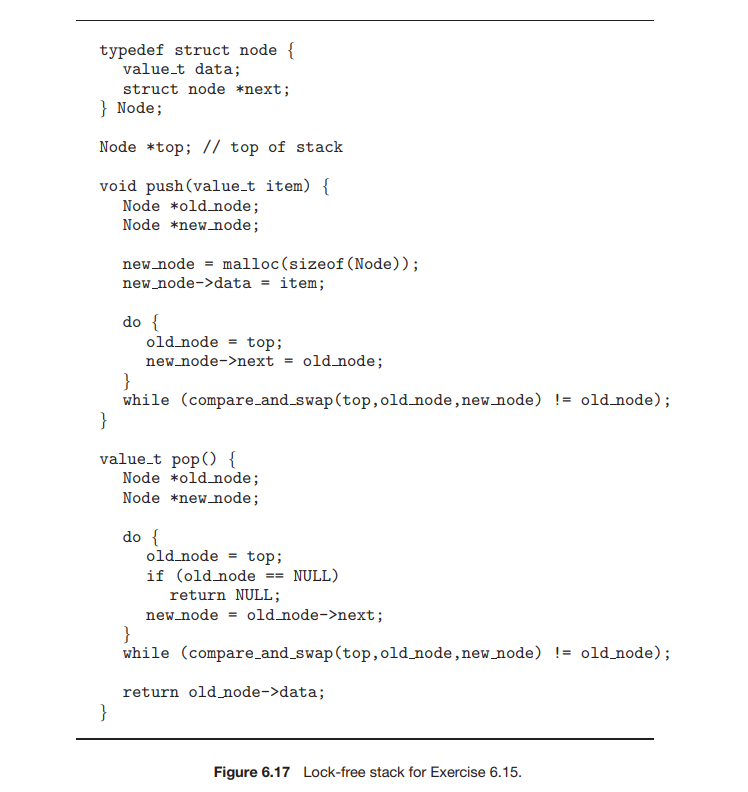


**Answer:**  
Yes, this lock-free stack implementation **is free from race conditions** (assuming a correctly functioning atomic `compare_and_swap()`). The algorithm uses a common pattern for lock-free stacks:

- **`push()`:** It creates a new node, sets its `next` to the current `top`, and then uses a CAS loop to atomically update `top` to the new node only if `top` hasn't changed since it was read. If the CAS fails (because another thread updated `top`), it retries with the new `top`.
- **`pop()`:** It reads `top`, if not NULL, sets `new_node` to `top->next`, and uses a CAS loop to atomically set `top` to `new_node` only if `top` is unchanged. If CAS fails, it retries.

**Why it's race-condition-free:**  
The CAS operation ensures that the update to the shared `top` pointer is atomic and conditional on it matching the expected value. This prevents the classic "lost update" or "incorrect pointer" issues in concurrent stack operations. However, note that this implementation is susceptible to the **ABA problem**: between reading `old_node` and attempting the CAS, `top` could have changed to a different node and then back to the same `old_node` (e.g., if other threads performed pushes and pops), causing the CAS to succeed incorrectly. The ABA problem is a subtle race condition that can lead to data corruption in some cases (e.g., if node memory is reused). The code in Figure 6.17 does not include protections against ABA (such as version counters or safe memory reclamation). So, while it is race-condition-free regarding pointer updates due to CAS, it may have **ABA-related races** in environments with dynamic memory allocation and reuse.

---

## **Exercise 6.16**
**Question:**  
One approach for using compare and swap() for implementing a spinlock is as follows:
```
void lock_spinlock(int *lock) {
while (compare_and_swap(lock, 0, 1) != 0)
; /* spin */
}
```
A suggested alternative approach is to use the “compare and compare-and-swap” idiom, which checks the status of the lock before invoking the compare and swap() operation. (The rationale behind this approach is to invoke compare and swap() only if the lock is currently available.) This strategy is shown below:
```
void lock_spinlock(int *lock) {
while (true) {
if (*lock == 0) {
/* lock appears to be available */
if (!compare_and_swap(lock, 0, 1))
break;
}
}
}
```
Does this “compare and compare-and-swap” idiom work appropriately for implementing spinlocks? If so, explain. If not, illustrate how the integrity of the lock is compromised.

**Answer:**  
No, the "compare and compare-and-swap" idiom **does not work appropriately** for implementing spinlocks in a concurrent environment. It compromises the integrity of the lock by allowing **multiple threads to potentially acquire the lock simultaneously**, violating mutual exclusion.

**How integrity is compromised:**  
Between the check `if (*lock == 0)` and the subsequent `compare_and_swap(lock, 0, 1)`, another thread can modify `*lock`. For example:
1. Thread A checks `*lock`, finds it 0 (available).
2. Before Thread A executes its CAS, Thread B also checks `*lock`, finds it 0, and successfully performs a CAS, setting `*lock` to 1 and acquiring the lock.
3. Thread A now proceeds to its CAS: it expects `*lock` to be 0 (but it's now 1), so the CAS fails (returns a non-zero value). However, because the code uses `if (!compare_and_swap(...))` (i.e., breaks only if CAS returns 0/false), the CAS failure means it does **not** break out of the loop. Instead, it continues spinning.
4. Thread B releases the lock (sets `*lock` back to 0).
5. Thread A, still in its loop, will again see `*lock == 0` in the next iteration, and may now successfully CAS, acquiring the lock.
6. Meanwhile, another Thread C could also see the lock as 0 and compete.

This is not inherently incorrect—it is essentially a more complicated version of spinning with a check. The **critical flaw** is that the `break` condition is incorrectly placed. The original CAS-based spinlock breaks when CAS *succeeds* (returns the expected old value, 0). In this flawed idiom, the `if (!compare_and_swap(...))` breaks when CAS returns false (i.e., when it *fails*), which is the opposite of what's needed. If we interpret `compare_and_swap` as returning the *old* value (as is typical), then `!compare_and_swap` makes no sense. Assuming a typical CAS that returns the old value, the correct check to break would be `if (compare_and_swap(lock, 0, 1) == 0)`. The provided code's logic is reversed.

Even if the logic were corrected, the initial read `*lock == 0` is **optimistic but harmless**; it may reduce expensive CAS calls when the lock is busy, but does not affect correctness if the CAS is ultimately used to acquire atomically. However, with the logic as written (breaking on CAS failure), it allows a thread to skip acquiring when it should, possibly spinning forever or breaking without acquiring.

---

## **Exercise 6.17**
**Question:**  
Some semaphore implementations provide a function getValue() that returns the current value of a semaphore. This function may, for instance, be invoked prior to calling wait() so that a process will only call wait() while the value of the semaphore is > 0, thereby preventing blocking while waiting for the semaphore. For example:
```
if (getValue(&sem) > 0)
wait(&sem);
```
Many developers argue against such a function and discourage its use. Describe a potential problem that could occur when using the function getValue() in this scenario.

**Answer:**  
The problem is a **race condition** between the `getValue()` check and the subsequent `wait()`. The semaphore value can change after `getValue()` returns a positive value but before `wait()` is called, potentially causing the thread to block unexpectedly or leading to incorrect program logic.

**Scenario:**  
1. Thread A calls `getValue(&sem)` and gets 1.
2. The scheduler switches to Thread B, which calls `wait(&sem)`, decrementing the semaphore to 0.
3. Thread B might then perform a `signal(&sem)`, incrementing it back to 1.
4. Thread A resumes and calls `wait(&sem)`. The semaphore is 1, so it proceeds without blocking. This might be okay in this sequence, but consider a different interleaving:
   - Thread A gets value 1.
   - Thread B calls `wait(&sem)`, decrementing to 0.
   - Thread A calls `wait(&sem)`. Now the value is 0, so Thread A **blocks**, contrary to the intention of the `if` check.

Thus, the check `getValue() > 0` does **not** guarantee that `wait()` will not block, because the condition is not atomic. This can lead to bugs where the program assumes non-blocking behavior. Additionally, reliance on `getValue()` often indicates a design flaw—semaphores are meant to be used with `wait()` and `signal()` as atomic operations; polling their value breaks the synchronization abstraction.

---

## **Exercise 6.18**
**Question:**  
The first known correct software solution to the critical-section problem for two processes was developed by Dekker. The two processes, P0 and P1, share the following variables:
```
boolean flag[2]; /* initially false */
int turn;
```
The structure of process Pi (i == 0 or 1) is shown in Figure 6.18. The other process is Pj (j == 1 or 0). Prove that the algorithm satisfies all three requirements for the critical-section problem.

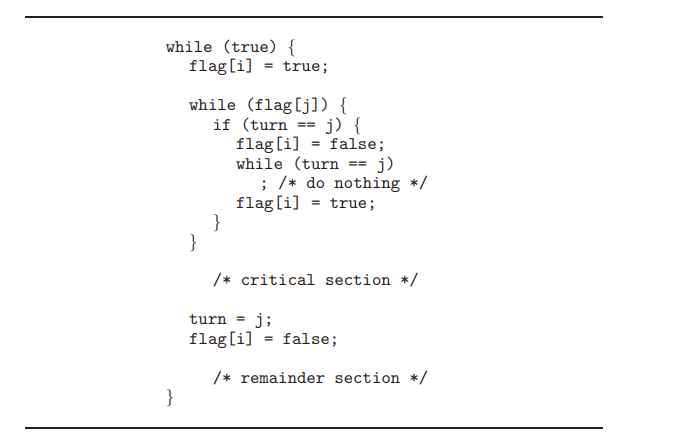



**Answer:**  
**Dekker's Algorithm Proof:**  
The three requirements are **mutual exclusion**, **progress**, and **bounded waiting**.

**1. Mutual Exclusion:**  
- A process Pi enters its critical section only if either `flag[j]` is false or `turn == i`.
- Suppose both processes are in their critical sections simultaneously. Then both `flag[0]` and `flag[1]` must be true. Since `turn` can be either 0 or 1, assume `turn == 0`. Then P1 could only be in its critical section if `flag[0]` were false (since `turn == 0` and `j=0` for P1, the condition `while (flag[j])` requires `flag[0]` to be false to exit the loop). But `flag[0]` is true (P0 is in CS). Contradiction. Similarly for `turn == 1`. Thus, both cannot be in CS simultaneously.

**2. Progress:**  
- If no process is in its critical section and one or more want to enter, the decision of who enters cannot be postponed indefinitely. The `turn` variable ensures that if both processes set their `flag` to true, the one with `turn` set to its index will defer by setting its flag to false, allowing the other to proceed. The waiting process will then set its flag back to true and check `turn` again. Since `turn` is set to `j` by the process exiting the CS, the waiting process will eventually see `turn == i` and enter. Deadlock is avoided because the process that finds `turn == j` will release `flag[i]` temporarily, allowing the other to progress.

**3. Bounded Waiting:**  
- Once a process Pi has set `flag[i]=true`, the other process Pj can enter its CS at most once before Pi gets a turn. When Pj exits, it sets `turn = i`. Pi, which may be spinning in the inner `while (turn == j)` loop, will then find `turn == i`, set `flag[i]=true` again, and enter its CS. Thus, a process waits for at most one turn of the other process.

Therefore, Dekker's algorithm satisfies all three requirements.

---

## **Exercise 6.19**
**Question:**  
The first known correct software solution to the critical-section problem for n processes with a lower bound on waiting of n − 1 turns was presented by Eisenberg and McGuire. The processes share the following variables:
```
enum pstate {idle, want_in, in_cs};
pstate flag[n];
int turn;
```
All the elements of flag are initially idle. The initial value of turn is immaterial (between 0 and n-1). The structure of process Pi is shown in Figure 6.19. Prove that the algorithm satisfies all three requirements for the critical-section problem.


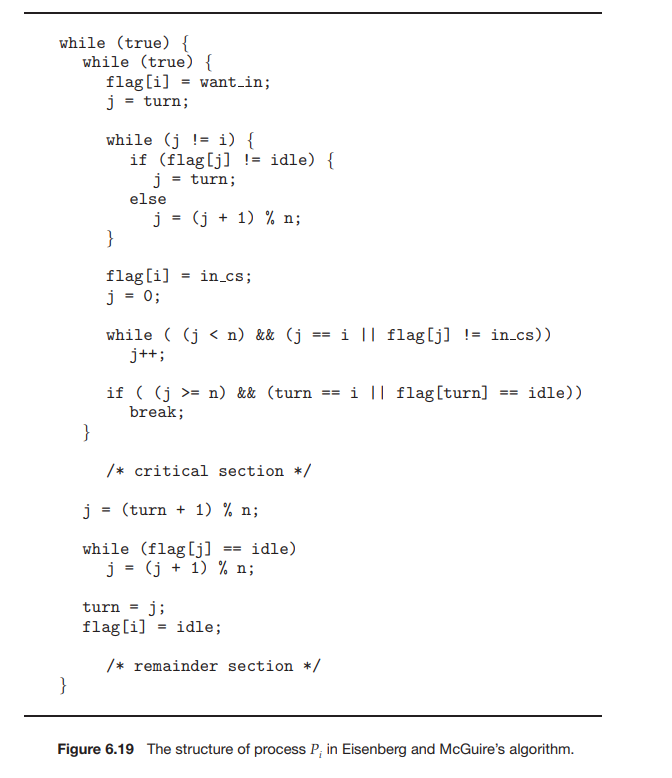




**Answer:**  
**Eisenberg and McGuire's Algorithm Proof:**  
The algorithm uses a rotating priority mechanism.

**1. Mutual Exclusion:**  
- A process Pi enters the critical section only when it has set `flag[i] = in_cs` and verified that no other process is in `in_cs` state (`while ((j < n) && (j == i || flag[j] != in_cs))` ensures all other `flag[j]` are not `in_cs`). Also, it ensures that either it is its turn (`turn == i`) or the current `turn` process is idle. This guarantees that only one process can be in the `in_cs` state at a time.

**2. Progress:**  
- If no process is in CS and some processes want to enter, the `turn` variable and the scanning loop ensure that one will eventually pass the conditions. The algorithm avoids deadlock because processes waiting will repeatedly scan; the `turn` variable rotates, giving each process a chance. A process unable to enter will eventually see `turn == i` or `flag[turn] == idle` and break into CS.

**3. Bounded Waiting:**  
- The waiting bound is n-1 turns. After a process Pi exits the CS, it updates `turn` to the next process with `flag[j] != idle` in cyclic order. This ensures that processes wanting to enter are served in a round-robin fashion relative to the `turn` pointer. A process Pi will wait while at most n-1 other processes enter the CS before it, because `turn` will eventually point to Pi after serving others in the waiting set.

Thus, the algorithm satisfies mutual exclusion, progress, and bounded waiting for n processes.
